## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

import DataProcessor
import srmse
import vae

## Choose Variables and Preprocess

In [2]:
# Load in the persons PUMS dataset for WA state
p_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_p53.csv")
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

# Filter to desired variables (numeric then categorical)
pums_data_h = h_df[['SERIALNO','HINCP','NP','VEH','BLD','ACCESS']]
pums_data_p = p_df[['SERIALNO','PWGTP','PINCP','AGEP','JWMNP','SEX','SCHL','MAR','COW','DPHY','DEYE','DREM','RAC1P']]
del h_df
del p_df
pums_data = pd.merge(pums_data_p, pums_data_h, on='SERIALNO')
pums_data = pums_data.drop(labels=['SERIALNO'], axis=1)

# Convert numerical variables to categorical bins
pums_data['HINCP'], hincp_bins = pd.qcut(pums_data['HINCP'], q=10, labels=False, retbins=True)
pums_data['AGEP'], agep_bins = pd.qcut(pums_data['AGEP'], q=10, labels=False, retbins=True)
pums_data['JWMNP'], jwmnp_bins = pd.qcut(pums_data['JWMNP'], q=10, labels=False, retbins=True)
pums_data['PINCP'], pincp_bins = pd.qcut(pums_data['PINCP'], q=10, labels=False, retbins=True)


# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

# Scale by the person-weights to get true population
# pums_data = pums_data.reindex(pums_data.index.repeat(pums_data['PWGTP']))
pums_data = pums_data.drop('PWGTP', axis=1)
pums_data_p = pums_data_p.drop('PWGTP', axis=1)
# pums_data = pums_data.sample(150000)
pums_data

Dataset n=359075 pre-cleaning
Dataset n=150203 post-cleaning


,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P,HINCP,NP,VEH,BLD,ACCESS
4,9.0,6,9.0,1,21.0,1,1.0,2.0,2,2.0,1,9.0,3,3.0,2.0,1.0
5,7.0,6,4.0,2,21.0,1,3.0,2.0,2,2.0,1,9.0,3,3.0,2.0,1.0
7,5.0,7,6.0,1,19.0,1,3.0,2.0,2,2.0,1,3.0,2,3.0,1.0,3.0
8,4.0,6,2.0,2,16.0,1,1.0,2.0,2,2.0,1,3.0,2,3.0,1.0,3.0
9,2.0,4,0.0,1,5.0,5,1.0,2.0,2,2.0,9,1.0,5,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356007,7.0,4,8.0,1,21.0,1,1.0,2.0,2,2.0,6,3.0,3,2.0,2.0,1.0
356010,8.0,3,9.0,1,18.0,1,1.0,2.0,2,2.0,1,6.0,4,2.0,3.0,1.0
356013,7.0,5,9.0,1,18.0,1,1.0,2.0,2,2.0,1,6.0,3,4.0,2.0,1.0
356014,7.0,5,6.0,2,19.0,1,1.0,2.0,2,2.0,1,6.0,3,4.0,2.0,1.0


In [3]:
HH_IDX = pums_data_p.shape[1] - 1  # Index of household variables start
VAR_DIM = pums_data.shape[1]  # Length of all variables before OHE
VAR_NAMES = pums_data.columns  # Names of all variables before OHE
HH_VAR_NAMES = pums_data_h.columns  # Names of the hh variables

del pums_data_p
del pums_data_h

# Split categorical data into OHE vars, save num classes per variable, as well as numeric encodings per variable
dummies_list = []
pums_encodings_list = []
for x in range(VAR_DIM):
    dummies = pums_data.iloc[:,x]
    pums_encodings_list.append(np.unique(dummies.values))
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
    del dummies
CAT_LENGTHS = [x.shape[1] for x in dummies_list]
print(f"Categorical variable class lengths: {CAT_LENGTHS}")

Categorical variable class lengths: [10, 9, 10, 2, 24, 5, 8, 2, 2, 2, 9, 10, 18, 7, 10, 3]


In [4]:
# Final data frame after encoding OHE
model_data_df = pd.DataFrame()
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
del ohe_var
MANIFEST_DIM = model_data_df.shape[1]
HH_IDX_MANIFEST = sum(CAT_LENGTHS[:HH_IDX])

# Add columns for original household variables; these will be used as conditionals
# model_data_df = pd.concat([model_data_df, model_data_df.iloc[:,HH_IDX_MANIFEST:]], axis=1)

# Preview data that will be fed into model
model_data_df

,PINCP__0.0,PINCP__1.0,PINCP__2.0,PINCP__3.0,PINCP__4.0,PINCP__5.0,PINCP__6.0,PINCP__7.0,PINCP__8.0,PINCP__9.0,...,BLD__4.0,BLD__5.0,BLD__6.0,BLD__7.0,BLD__8.0,BLD__9.0,BLD__10.0,ACCESS__1.0,ACCESS__2.0,ACCESS__3.0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356007,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
356010,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
356013,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
356014,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# Separate into train/test data
model_data = model_data_df.values
train_idx = round(len(model_data)*.7)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]

print(f"Training on {train_idx} samples")

Training on 105142 samples


## Set Parameters and Define Model

In [6]:
# Grid Search SRMSE 1
# BATCH_SIZES = [64, 128, 256, 512, 1024]
# EPOCHS = [1000]
# LATENT_DIMS = [4, 6, 8]
# HIDDEN_DIMS = [8, 16, 32, 64]
# KL_WEIGHTS = [.01, .05, .1, 1.0]
# [313.08608531951904, 11.0505690574646, 0.02598349649036663, 0.006970305382407434, [512, 1000, 6, 64, 0.1]]
# [290.68157863616943, 6.595394611358643, 0.026173123522601732, 0.00692727365319053, [256, 1000, 6, 64, 0.1]]
# [99.60163021087646, 6.652237892150879, 0.028944710845045213, 0.0071278053533916155, [1024, 1000, 8, 16, 0.05]]

# Hyperparameters
BATCH_SIZE = 1024
EPOCHS = 1000
LATENT_DIM = 8
HIDDEN_DIM = 16
KL_WEIGHT = .05

## Training

In [7]:
val_loss = []
val_epochs = []
class validationCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            val_epochs.append(epoch)
            # Use random sample of 1000 from test data to validate the model
            idx = np.random.randint(test_data.shape[0], size=1000)
            val_data = test_data[idx]
            results = vae_model.predict(val_data)
            loss_cat = vae.get_reconstruction_loss(val_data, results, CAT_LENGTHS)
            val_loss.append(loss_cat)

In [21]:
# # Load in the synthetic households
# synth_hh_df = pd.read_csv('data/synthetic_populations/wa_households.csv')
# synth_hh_ohe_df = pd.read_csv('data/synthetic_populations/wa_households_raw.csv')

# # Multiply the inputs by the number of persons per household (hh of size 3 becomes 3 rows with same scaled hh inputs)
# synth_hh_df['HH_ID'] = synth_hh_df.index
# synth_hh_ohe_df = synth_hh_ohe_df.reindex(synth_hh_ohe_df.index.repeat(synth_hh_df['NP']))
# synth_hh_df = synth_hh_df.reindex(synth_hh_df.index.repeat(synth_hh_df['NP']))

def testModel(test_vae, latent_dim):
    # How many synthetic households to fill
    POP_SIZE = len(synth_hh_ohe_df)

    # Generate random normal sample to represent each latent variable, for each row (different person per row)
    np.random.seed(42)
    epsilon = np.random.normal(loc=0, scale=1, size=(POP_SIZE, latent_dim))

    start_time = time.time()
    # Generate persons; each person has unique latent input, plus shared hh inputs with their household
    results = vae_model.decoder.predict([epsilon, synth_hh_ohe_df.values])
    gen_time = time.time() - start_time

    # Convert the test results from logits to values
    synth_p_df = pd.DataFrame()
    for i, x in enumerate(results[0]):
        result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
        result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
        synth_p_df = pd.concat([synth_p_df, result_df], axis=1)
    synth_p_df.columns = VAR_NAMES

    # Assign the control variables from the synthetic households to individuals (replace what came from the model)
    for var in HH_VAR_NAMES[1:]:
        synth_p_df[f"{var}"] = synth_hh_df[f"{var}"].values

    srmse_uni = srmse.calculateSRMSE(synth_p_df, pums_data.sample(POP_SIZE, replace=True, random_state=42))
    srmse_bi = srmse.calculateBivariateSRMSE(synth_p_df, pums_data.sample(POP_SIZE, replace=True, random_state=42))

    return gen_time, srmse_uni, srmse_bi

In [9]:
# # Use grid search to train model and get results for many different hyperparameters
# grid_search_results = []
# for bs in BATCH_SIZES:
#     for e in EPOCHS:
#         for ld in LATENT_DIMS:
#             for hd in HIDDEN_DIMS:
#                 for klw in KL_WEIGHTS:
#                     print(f"[{bs}, {e}, {ld}, {hd}, {klw}]")
#                     start_time = time.time()
#                     vae = VAE.VAE(MANIFEST_DIM, hd, ld, CAT_LENGTHS, HH_IDX, klw)
#                     vae.compile(optimizer=keras.optimizers.Adam())
#                     history = vae.fit(train_data, epochs=e, batch_size=bs, callbacks=[validationCallback()], verbose=0)
#                     train_time = (time.time()-start_time)
#                     gen_time, srmse_uni, srmse_bi = testModel(test_vae=vae, latent_dim=ld)
#                     results = [train_time, gen_time, srmse_uni, srmse_bi, [bs,e,ld,hd,klw]]
#                     grid_search_results.append(results)

# # Find the best results for each metric in the grid search
# min_srmse_uni_idx = 0
# min_srmse_uni_value = 999999999
# min_srmse_bi_idx = 0
# min_srmse_bi_value = 999999999
# min_eff_idx = 0
# min_eff_value = 999999999
# for i, result in enumerate(grid_search_results):
#     tot_time = result[0]+result[1]
#     time_eff = (result[2]+result[3] / 2) * tot_time
#     if result[2] < min_srmse_uni_value:
#         min_srmse_uni_idx = i
#         min_srmse_uni_value = result[2]
#     if result[3] < min_srmse_bi_value:
#         min_srmse_bi_idx = i
#         min_srmse_bi_value = result[3]
#     if time_eff < min_eff_value:
#         min_eff_idx = i
#         min_eff_value = time_eff

# # Display the results
# print(grid_search_results[min_srmse_uni_idx])
# print(grid_search_results[min_srmse_bi_idx])
# print(grid_search_results[min_eff_idx])

In [10]:
# For testing as a VAE rather than CVAE
HH_IDX = len(CAT_LENGTHS)
HH_IDX

16

In [11]:
# Train the model using single set of hyperparameters
start_time = time.time()
vae_model = vae.VAE(MANIFEST_DIM, HIDDEN_DIM, LATENT_DIM, CAT_LENGTHS, HH_IDX, KL_WEIGHT)
vae_model.compile(optimizer=keras.optimizers.Adam())
history = vae_model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[validationCallback()])
print(f"--- {time.time() - start_time} seconds ---")

Metal device set to: Apple M1


2021-12-20 12:27:55.308200: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-20 12:27:55.308328: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-12-20 12:27:55.836670: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/1000


2021-12-20 12:27:56.536738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - ETA: 0s - tot_loss: 24.9891 - rec_loss: 24.7357 - kl_loss: 0.2533

2021-12-20 12:28:05.092415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 10s 61ms/step - tot_loss: 24.9891 - rec_loss: 24.7357 - kl_loss: 0.2533
Epoch 2/1000
103/103 [==============================] - 5s 47ms/step - tot_loss: 19.7192 - rec_loss: 19.4358 - kl_loss: 0.2833
Epoch 3/1000
103/103 [==============================] - 5s 45ms/step - tot_loss: 18.5771 - rec_loss: 18.2350 - kl_loss: 0.3421
Epoch 4/1000
103/103 [==============================] - 5s 45ms/step - tot_loss: 17.8210 - rec_loss: 17.4169 - kl_loss: 0.4041
Epoch 5/1000
103/103 [==============================] - 5s 45ms/step - tot_loss: 17.2428 - rec_loss: 16.8144 - kl_loss: 0.4284
Epoch 6/1000
103/103 [==============================] - 5s 46ms/step - tot_loss: 16.7462 - rec_loss: 16.2984 - kl_loss: 0.4478
Epoch 7/1000
103/103 [==============================] - 5s 45ms/step - tot_loss: 16.2165 - rec_loss: 15.7325 - kl_loss: 0.4840
Epoch 8/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 15.6407 - rec_loss: 15.1022 - kl_loss: 0.5

103/103 [==============================] - 5s 44ms/step - tot_loss: 10.6398 - rec_loss: 9.8208 - kl_loss: 0.8190
Epoch 66/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 10.6045 - rec_loss: 9.7849 - kl_loss: 0.8196
Epoch 67/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 10.5718 - rec_loss: 9.7499 - kl_loss: 0.8219
Epoch 68/1000
103/103 [==============================] - 5s 45ms/step - tot_loss: 10.5373 - rec_loss: 9.7134 - kl_loss: 0.8239
Epoch 69/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 10.5050 - rec_loss: 9.6801 - kl_loss: 0.8250
Epoch 70/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 10.4724 - rec_loss: 9.6443 - kl_loss: 0.8281
Epoch 71/1000
103/103 [==============================] - 5s 46ms/step - tot_loss: 10.4368 - rec_loss: 9.6071 - kl_loss: 0.8298
Epoch 72/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 10.4025 - rec_loss: 9.5706 - kl_loss: 0.832

103/103 [==============================] - 5s 44ms/step - tot_loss: 8.7129 - rec_loss: 7.7860 - kl_loss: 0.9269
Epoch 130/1000
103/103 [==============================] - 4s 44ms/step - tot_loss: 8.6963 - rec_loss: 7.7680 - kl_loss: 0.9284
Epoch 131/1000
103/103 [==============================] - 5s 46ms/step - tot_loss: 8.6775 - rec_loss: 7.7478 - kl_loss: 0.9296
Epoch 132/1000
103/103 [==============================] - 4s 43ms/step - tot_loss: 8.6582 - rec_loss: 7.7281 - kl_loss: 0.9301
Epoch 133/1000
103/103 [==============================] - 4s 44ms/step - tot_loss: 8.6384 - rec_loss: 7.7077 - kl_loss: 0.9307
Epoch 134/1000
103/103 [==============================] - 4s 43ms/step - tot_loss: 8.6207 - rec_loss: 7.6893 - kl_loss: 0.9314
Epoch 135/1000
103/103 [==============================] - 4s 44ms/step - tot_loss: 8.6026 - rec_loss: 7.6705 - kl_loss: 0.9321
Epoch 136/1000
103/103 [==============================] - 4s 44ms/step - tot_loss: 8.5868 - rec_loss: 7.6529 - kl_loss: 0.9339

103/103 [==============================] - 5s 44ms/step - tot_loss: 7.7834 - rec_loss: 6.8218 - kl_loss: 0.9617
Epoch 194/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 7.7740 - rec_loss: 6.8122 - kl_loss: 0.9618
Epoch 195/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 7.7650 - rec_loss: 6.8027 - kl_loss: 0.9623
Epoch 196/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 7.7523 - rec_loss: 6.7894 - kl_loss: 0.9629
Epoch 197/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 7.7417 - rec_loss: 6.7788 - kl_loss: 0.9629
Epoch 198/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 7.7322 - rec_loss: 6.7686 - kl_loss: 0.9636
Epoch 199/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 7.7204 - rec_loss: 6.7567 - kl_loss: 0.9637
Epoch 200/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 7.7127 - rec_loss: 6.7486 - kl_loss: 0.9641

103/103 [==============================] - 5s 44ms/step - tot_loss: 7.2315 - rec_loss: 6.2508 - kl_loss: 0.9808
Epoch 258/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 7.2243 - rec_loss: 6.2436 - kl_loss: 0.9808
Epoch 259/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 7.2176 - rec_loss: 6.2366 - kl_loss: 0.9810
Epoch 260/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 7.2114 - rec_loss: 6.2300 - kl_loss: 0.9814
Epoch 261/1000
103/103 [==============================] - 5s 46ms/step - tot_loss: 7.2050 - rec_loss: 6.2230 - kl_loss: 0.9820
Epoch 262/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 7.1983 - rec_loss: 6.2164 - kl_loss: 0.9820
Epoch 263/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 7.1917 - rec_loss: 6.2090 - kl_loss: 0.9827
Epoch 264/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 7.1852 - rec_loss: 6.2031 - kl_loss: 0.9821

103/103 [==============================] - 5s 46ms/step - tot_loss: 6.8983 - rec_loss: 5.9019 - kl_loss: 0.9963
Epoch 322/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.8937 - rec_loss: 5.8989 - kl_loss: 0.9948
Epoch 323/1000
103/103 [==============================] - 5s 45ms/step - tot_loss: 6.8905 - rec_loss: 5.8943 - kl_loss: 0.9962
Epoch 324/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.8853 - rec_loss: 5.8890 - kl_loss: 0.9963
Epoch 325/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.8815 - rec_loss: 5.8856 - kl_loss: 0.9959
Epoch 326/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.8773 - rec_loss: 5.8814 - kl_loss: 0.9958
Epoch 327/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.8770 - rec_loss: 5.8802 - kl_loss: 0.9967
Epoch 328/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.8731 - rec_loss: 5.8766 - kl_loss: 0.9965

103/103 [==============================] - 4s 43ms/step - tot_loss: 6.6951 - rec_loss: 5.6942 - kl_loss: 1.0009
Epoch 386/1000
103/103 [==============================] - 4s 44ms/step - tot_loss: 6.6914 - rec_loss: 5.6908 - kl_loss: 1.0006
Epoch 387/1000
103/103 [==============================] - 4s 44ms/step - tot_loss: 6.6891 - rec_loss: 5.6877 - kl_loss: 1.0014
Epoch 388/1000
103/103 [==============================] - 4s 44ms/step - tot_loss: 6.6847 - rec_loss: 5.6836 - kl_loss: 1.0011
Epoch 389/1000
103/103 [==============================] - 4s 44ms/step - tot_loss: 6.6813 - rec_loss: 5.6805 - kl_loss: 1.0008
Epoch 390/1000
103/103 [==============================] - 4s 44ms/step - tot_loss: 6.6795 - rec_loss: 5.6773 - kl_loss: 1.0021
Epoch 391/1000
103/103 [==============================] - 5s 46ms/step - tot_loss: 6.6779 - rec_loss: 5.6762 - kl_loss: 1.0017
Epoch 392/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.6749 - rec_loss: 5.6731 - kl_loss: 1.0018

103/103 [==============================] - 5s 44ms/step - tot_loss: 6.5235 - rec_loss: 5.5108 - kl_loss: 1.0127
Epoch 450/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.5188 - rec_loss: 5.5072 - kl_loss: 1.0116
Epoch 451/1000
103/103 [==============================] - 5s 46ms/step - tot_loss: 6.5158 - rec_loss: 5.5036 - kl_loss: 1.0123
Epoch 452/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.5101 - rec_loss: 5.4995 - kl_loss: 1.0106
Epoch 453/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.5091 - rec_loss: 5.4972 - kl_loss: 1.0119
Epoch 454/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.5055 - rec_loss: 5.4930 - kl_loss: 1.0125
Epoch 455/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.5036 - rec_loss: 5.4916 - kl_loss: 1.0120
Epoch 456/1000
103/103 [==============================] - 4s 44ms/step - tot_loss: 6.5006 - rec_loss: 5.4879 - kl_loss: 1.0127

103/103 [==============================] - 5s 44ms/step - tot_loss: 6.3565 - rec_loss: 5.3419 - kl_loss: 1.0146
Epoch 514/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.3563 - rec_loss: 5.3410 - kl_loss: 1.0153
Epoch 515/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.3527 - rec_loss: 5.3391 - kl_loss: 1.0136
Epoch 516/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.3525 - rec_loss: 5.3379 - kl_loss: 1.0146
Epoch 517/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.3485 - rec_loss: 5.3346 - kl_loss: 1.0139
Epoch 518/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.3470 - rec_loss: 5.3325 - kl_loss: 1.0145
Epoch 519/1000
103/103 [==============================] - 5s 45ms/step - tot_loss: 6.3477 - rec_loss: 5.3325 - kl_loss: 1.0152
Epoch 520/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.3423 - rec_loss: 5.3291 - kl_loss: 1.0132

103/103 [==============================] - 5s 44ms/step - tot_loss: 6.2423 - rec_loss: 5.2356 - kl_loss: 1.0067
Epoch 578/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.2398 - rec_loss: 5.2334 - kl_loss: 1.0064
Epoch 579/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.2383 - rec_loss: 5.2319 - kl_loss: 1.0064
Epoch 580/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.2374 - rec_loss: 5.2312 - kl_loss: 1.0062
Epoch 581/1000
103/103 [==============================] - 5s 46ms/step - tot_loss: 6.2345 - rec_loss: 5.2289 - kl_loss: 1.0056
Epoch 582/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.2336 - rec_loss: 5.2278 - kl_loss: 1.0057
Epoch 583/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.2333 - rec_loss: 5.2275 - kl_loss: 1.0058
Epoch 584/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.2286 - rec_loss: 5.2234 - kl_loss: 1.0052

103/103 [==============================] - 5s 46ms/step - tot_loss: 6.1531 - rec_loss: 5.1521 - kl_loss: 1.0010
Epoch 642/1000
103/103 [==============================] - 4s 44ms/step - tot_loss: 6.1498 - rec_loss: 5.1501 - kl_loss: 0.9997
Epoch 643/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.1506 - rec_loss: 5.1510 - kl_loss: 0.9996
Epoch 644/1000
103/103 [==============================] - 4s 44ms/step - tot_loss: 6.1477 - rec_loss: 5.1480 - kl_loss: 0.9998
Epoch 645/1000
103/103 [==============================] - 4s 43ms/step - tot_loss: 6.1468 - rec_loss: 5.1463 - kl_loss: 1.0004
Epoch 646/1000
103/103 [==============================] - 4s 44ms/step - tot_loss: 6.1462 - rec_loss: 5.1460 - kl_loss: 1.0002
Epoch 647/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.1462 - rec_loss: 5.1449 - kl_loss: 1.0013
Epoch 648/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.1442 - rec_loss: 5.1440 - kl_loss: 1.0003

103/103 [==============================] - 5s 44ms/step - tot_loss: 6.0802 - rec_loss: 5.0800 - kl_loss: 1.0002
Epoch 706/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.0786 - rec_loss: 5.0784 - kl_loss: 1.0001
Epoch 707/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.0762 - rec_loss: 5.0770 - kl_loss: 0.9992
Epoch 708/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.0766 - rec_loss: 5.0769 - kl_loss: 0.9998
Epoch 709/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.0742 - rec_loss: 5.0738 - kl_loss: 1.0004
Epoch 710/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.0744 - rec_loss: 5.0741 - kl_loss: 1.0003
Epoch 711/1000
103/103 [==============================] - 5s 46ms/step - tot_loss: 6.0733 - rec_loss: 5.0726 - kl_loss: 1.0007
Epoch 712/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.0710 - rec_loss: 5.0710 - kl_loss: 1.0000

103/103 [==============================] - 5s 44ms/step - tot_loss: 6.0175 - rec_loss: 5.0142 - kl_loss: 1.0032
Epoch 770/1000
103/103 [==============================] - 4s 44ms/step - tot_loss: 6.0144 - rec_loss: 5.0112 - kl_loss: 1.0031
Epoch 771/1000
103/103 [==============================] - 5s 46ms/step - tot_loss: 6.0162 - rec_loss: 5.0133 - kl_loss: 1.0029
Epoch 772/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.0130 - rec_loss: 5.0107 - kl_loss: 1.0023
Epoch 773/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.0132 - rec_loss: 5.0111 - kl_loss: 1.0022
Epoch 774/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.0154 - rec_loss: 5.0113 - kl_loss: 1.0041
Epoch 775/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.0118 - rec_loss: 5.0088 - kl_loss: 1.0029
Epoch 776/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 6.0110 - rec_loss: 5.0081 - kl_loss: 1.0028

103/103 [==============================] - 5s 44ms/step - tot_loss: 5.9622 - rec_loss: 4.9557 - kl_loss: 1.0065
Epoch 834/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 5.9648 - rec_loss: 4.9568 - kl_loss: 1.0081
Epoch 835/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 5.9611 - rec_loss: 4.9541 - kl_loss: 1.0070
Epoch 836/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 5.9604 - rec_loss: 4.9536 - kl_loss: 1.0067
Epoch 837/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 5.9586 - rec_loss: 4.9521 - kl_loss: 1.0064
Epoch 838/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 5.9599 - rec_loss: 4.9529 - kl_loss: 1.0071
Epoch 839/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 5.9595 - rec_loss: 4.9515 - kl_loss: 1.0080
Epoch 840/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 5.9575 - rec_loss: 4.9496 - kl_loss: 1.0079

103/103 [==============================] - 5s 44ms/step - tot_loss: 5.9092 - rec_loss: 4.8988 - kl_loss: 1.0105
Epoch 898/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 5.9088 - rec_loss: 4.8980 - kl_loss: 1.0108
Epoch 899/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 5.9106 - rec_loss: 4.8986 - kl_loss: 1.0120
Epoch 900/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 5.9087 - rec_loss: 4.8978 - kl_loss: 1.0108
Epoch 901/1000
103/103 [==============================] - 5s 45ms/step - tot_loss: 5.9076 - rec_loss: 4.8964 - kl_loss: 1.0112
Epoch 902/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 5.9072 - rec_loss: 4.8968 - kl_loss: 1.0104
Epoch 903/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 5.9036 - rec_loss: 4.8934 - kl_loss: 1.0102
Epoch 904/1000
103/103 [==============================] - 4s 44ms/step - tot_loss: 5.9049 - rec_loss: 4.8936 - kl_loss: 1.0113

103/103 [==============================] - 5s 46ms/step - tot_loss: 5.8611 - rec_loss: 4.8497 - kl_loss: 1.0114
Epoch 962/1000
103/103 [==============================] - 5s 45ms/step - tot_loss: 5.8631 - rec_loss: 4.8513 - kl_loss: 1.0118
Epoch 963/1000
103/103 [==============================] - 5s 45ms/step - tot_loss: 5.8610 - rec_loss: 4.8508 - kl_loss: 1.0102
Epoch 964/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 5.8577 - rec_loss: 4.8475 - kl_loss: 1.0102
Epoch 965/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 5.8601 - rec_loss: 4.8482 - kl_loss: 1.0119
Epoch 966/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 5.8572 - rec_loss: 4.8461 - kl_loss: 1.0111
Epoch 967/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 5.8546 - rec_loss: 4.8442 - kl_loss: 1.0105
Epoch 968/1000
103/103 [==============================] - 5s 44ms/step - tot_loss: 5.8573 - rec_loss: 4.8458 - kl_loss: 1.0115

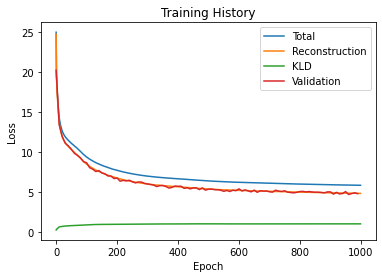

In [12]:
# Plot model loss/training progress
plt.plot(history.history['tot_loss'])
plt.plot(history.history['rec_loss'])
plt.plot(history.history['kl_loss'])
plt.plot(val_epochs, val_loss)
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Total","Reconstruction","KLD","Validation"], loc="upper right")
plt.show()

## Testing

2021-12-20 13:49:08.774134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


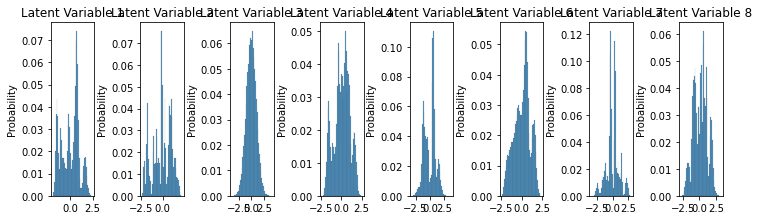

In [13]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae_model.encoder.predict(test_data[:,:MANIFEST_DIM])

# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=1, ncols=LATENT_DIM, figsize=(10,3))
fig.tight_layout(w_pad=2, h_pad=10)

for i in range(LATENT_DIM):
    sns.histplot(z[:,i], ax=axes[i], bins=50, stat="probability")
    axes[i].set_title(f"Latent Variable {i+1}")

In [14]:
# Draw predictions from test data
results = vae_model.predict(test_data)
loss_cat = vae.get_reconstruction_loss(test_data, results, CAT_LENGTHS)
print(f"Categorical Variable Loss: {loss_cat}")

Categorical Variable Loss: 4.812817573547363


In [15]:
# Convert the testing data from ohe to values
test_data_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_data_df = pd.concat([test_data_df, result_df], axis=1)
test_data_df.columns = VAR_NAMES

# Convert the test results from logits to values
test_results_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_results_df = pd.concat([test_results_df, result_df], axis=1)
test_results_df.columns = VAR_NAMES

## Generating Synthetic Population

In [16]:
# Load in the synthetic households
synth_hh_df = pd.read_csv('data/synthetic_populations/wa_households.csv')
synth_hh_ohe_df = pd.read_csv('data/synthetic_populations/wa_households_raw.csv')

# How many variables represent each household
HH_DIM = 5

In [17]:
# Multiply the inputs by the number of persons per household (hh of size 3 becomes 3 rows with same scaled hh inputs)
synth_hh_df['HH_ID'] = synth_hh_df.index
synth_hh_ohe_df = synth_hh_ohe_df.reindex(synth_hh_ohe_df.index.repeat(synth_hh_df['NP']))
synth_hh_df = synth_hh_df.reindex(synth_hh_df.index.repeat(synth_hh_df['NP']))

# How many synthetic households to fill
POP_SIZE = len(synth_hh_ohe_df)
print(POP_SIZE)

284644


In [18]:
# Generate random normal sample to represent each latent variable, for each row (different person per row)
epsilon = np.random.normal(loc=0, scale=1, size=(POP_SIZE, LATENT_DIM))

# Load the most recently trained model
# vae = keras.models.load_model('person_synthesizer')

start_time = time.time()

# Generate persons; each person has unique latent input, plus shared hh inputs with their household
# results = vae.decoder.predict([epsilon, synth_hh_ohe_df.values])
results = vae_model.decoder.predict([epsilon, epsilon[:,LATENT_DIM:]])  # Nothing is actually in the second input

print(f"--- {time.time() - start_time} seconds ---")

del epsilon

# Convert the test results from logits to values
synth_p_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    synth_p_df = pd.concat([synth_p_df, result_df], axis=1)
synth_p_df.columns = VAR_NAMES

# Assign the control variables from the synthetic households to individuals (replace what came from the model)
# for var in HH_VAR_NAMES[1:]:
#     synth_p_df[f"{var}"] = synth_hh_df[f"{var}"].values

# Save the synthesized persons
synth_p_df.to_csv('data/synthetic_populations/wa_persons_100000_vae.csv', index=False)

2021-12-20 13:49:24.457345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


--- 56.91646695137024 seconds ---


/var/folders/6p/76scpql109v8rhf5gm61sr4c0000gn/T/ipykernel_10617/2597211144.py:3: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout(h_pad=40)


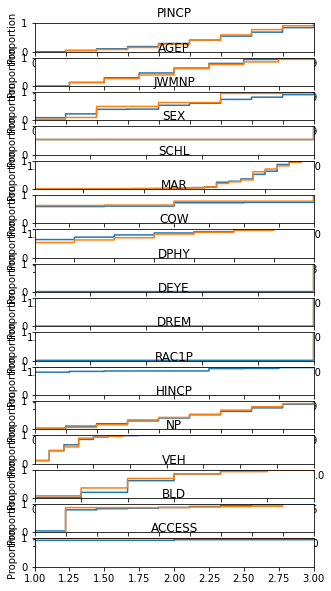

In [19]:
# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=1, figsize=(5,10))
fig.tight_layout(h_pad=40)

for i, var in enumerate(VAR_NAMES):
    sns.ecdfplot(data=pums_data, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    sns.ecdfplot(data=synth_p_df, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    axes[i].set_title(var)
    axes[i].set_xlabel(None)

In [22]:
testModel(test_vae=vae_model, latent_dim=LATENT_DIM)
# gen_time, srmse_uni, srmse_bi

ValueError: in user code:

    File "/Users/zack/miniforge3/envs/gensynth/lib/python3.9/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/Users/zack/miniforge3/envs/gensynth/lib/python3.9/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/zack/miniforge3/envs/gensynth/lib/python3.9/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/zack/miniforge3/envs/gensynth/lib/python3.9/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/Users/zack/miniforge3/envs/gensynth/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/zack/miniforge3/envs/gensynth/lib/python3.9/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 1 of layer "decoder" is incompatible with the layer: expected shape=(None, 0), found shape=(None, 48)
